# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Table of Contents - FORMAT

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import sys
!{sys.executable} -m pip install progressbar 
!{sys.executable} -m conda update pandas -y 
#!{sys.executable} conda update -n base conda

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  defaults
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    openssl-1.0.2t             |       h14c3975_0         3.1 MB  conda-forge
    pandas-0.24.2              |   py36hf484d3e_0        11

In [152]:
import pandas as pd
import numpy as np
import progressbar
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
print(sys.version)

3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [4]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

# <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

## <a class="anchor" id="Exploratory-Data-Analysis"> portfolio</a>

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [7]:
# Registro de ofertas das promoções

"""
Difficulty - dificuladade de cumprir a oferta
reward - Retorno em cumprir a tarefa
Channel - qual a importancia desta feature? Como trabalhar com ela?
"""


'\nDifficulty - dificuladade de cumprir a oferta\nreward - Retorno em cumprir a tarefa\nChannel - qual a importancia desta feature? Como trabalhar com ela?\n'

In [8]:
def cleaning_portfolio(df=portfolio):
    """
    INPUT:
        portfolio dataframe
        
    OUTPUT:
        A new datafrem with:
        - One-hot encode channels column
        - One-hot encode offer_type column   
        - With columns 
        ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    """
    
    # One-hot encode channels column
    # https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    
    # One-hot encode offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # Concat one-hot and df
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    return new_df

In [9]:
clean_portfolio = cleaning_portfolio(portfolio)
clean_portfolio

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


## <a class="anchor" id="Exploratory-Data-Analysis"> profile</a>

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
# Cadastro de clientes do aplicativo
"""
Incame =  Renda --- importante feature?

"""

'\nIncame =  Renda --- importante feature?\n\n'

In [13]:
def cleaning_profile(profile = profile):
    """
    INPUT:
        Profile datafram
        
    OUTPUT:
        A new dataframe whithout income values iqual to null and age iqual to 118
    """
    # drop lines with income = nan and age == 118
    new_df = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)
    
    # Age for range and One-hot 
    # https://dfrieds.com/data-analysis/bin-values-python-pandas
    range_ages = pd.cut(x=new_df["age"], bins=[18, 20, 29, 39, 49, 59, 69, 79, 89, 99, 102])
    
    # One-hot encode ages column
    ages_dummies = pd.get_dummies(range_ages)
    
    # Income for range and One-hot
    # One-hot encode income column
    range_income = pd.cut(x=new_df["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    
    # One-hot encode Gender column
    income_gender = pd.get_dummies(new_df["gender"])
    
    # Concat
    new_df = pd.concat([new_df, ages_dummies, income_dummies, income_gender], axis=1, sort=False)
    
    # Drop
    new_df = new_df.drop(["age", "gender", "income"], axis=1)
    
    return new_df    

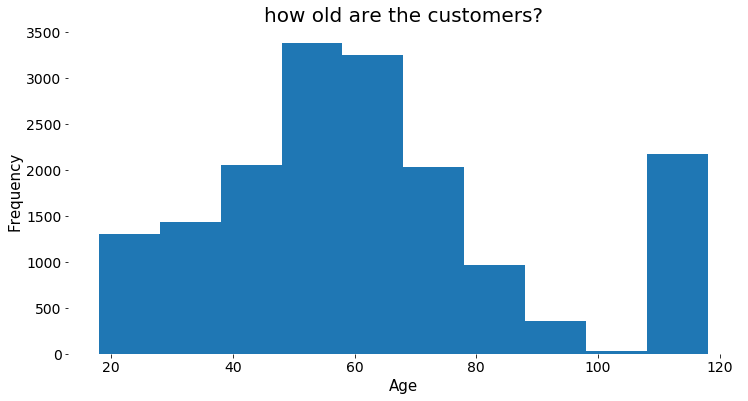

In [14]:
ax = profile["age"].plot.hist(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("how old are the customers?", fontsize=20)
ax.set_xlabel("Age", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

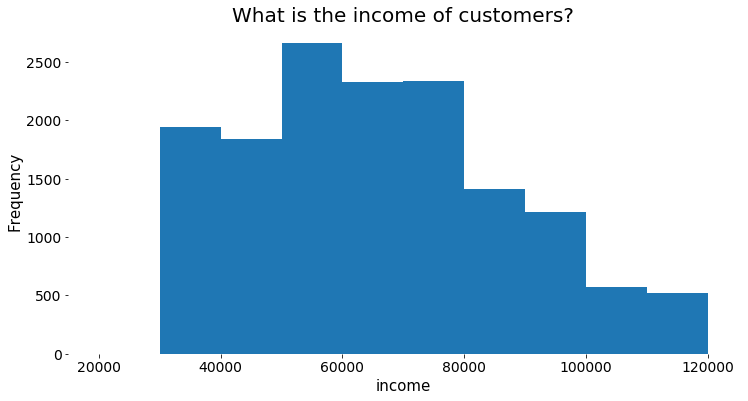

In [15]:
ax = profile["income"].plot.hist(
    range=(20000, 120000),
    bins = 10,
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("What is the income of customers?", fontsize=20)
ax.set_xlabel("income", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

In [16]:
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

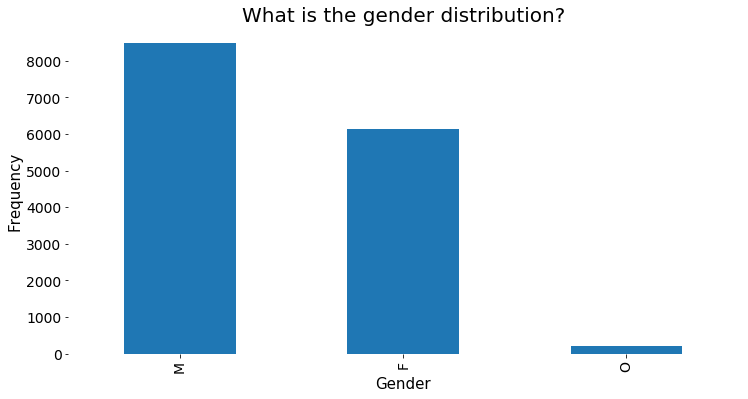

In [17]:
ax = profile["gender"].value_counts().plot.bar(
    #bins = 10,
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("What is the gender distribution?", fontsize=20)
ax.set_xlabel("Gender", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

### Cleaning profile

In [18]:
clean_profile = cleaning_profile()

In [19]:
clean_profile.head()

,became_member_on,id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,20170715,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,20170509,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,20180426,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,20180209,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,20171111,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [20]:
clean_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 24 columns):
became_member_on    14825 non-null int64
id                  14825 non-null object
(18, 20]            14825 non-null uint8
(20, 29]            14825 non-null uint8
(29, 39]            14825 non-null uint8
(39, 49]            14825 non-null uint8
(49, 59]            14825 non-null uint8
(59, 69]            14825 non-null uint8
(69, 79]            14825 non-null uint8
(79, 89]            14825 non-null uint8
(89, 99]            14825 non-null uint8
(99, 102]           14825 non-null uint8
(30000, 40000]      14825 non-null uint8
(40000, 50000]      14825 non-null uint8
(50000, 60000]      14825 non-null uint8
(60000, 70000]      14825 non-null uint8
(70000, 80000]      14825 non-null uint8
(80000, 90000]      14825 non-null uint8
(90000, 100000]     14825 non-null uint8
(100000, 110000]    14825 non-null uint8
(110000, 120000]    14825 non-null uint8
F                   14825 non

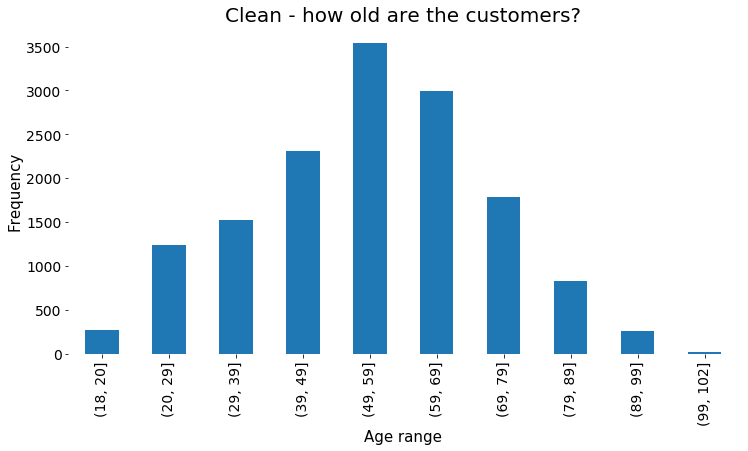

In [31]:
ax = clean_profile[clean_profile.columns[2:12]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("Clean - how old are the customers?", fontsize=20)
ax.set_xlabel("Age range", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

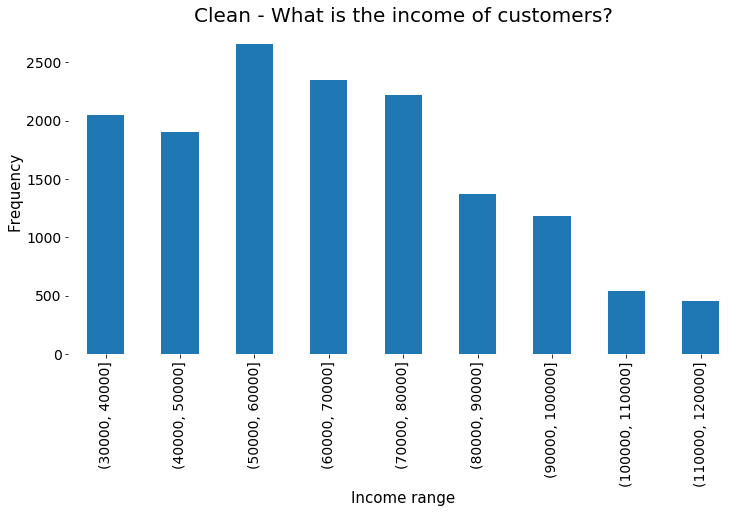

In [39]:
ax = clean_profile[clean_profile.columns[12:21]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("Clean - What is the income of customers?", fontsize=20)
ax.set_xlabel("Income range", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

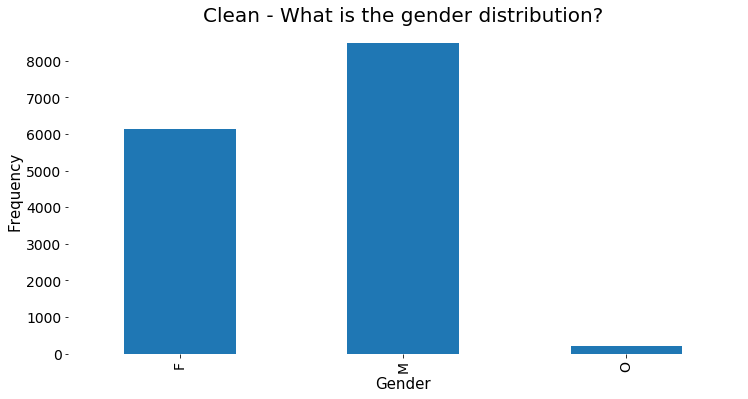

In [41]:
ax = clean_profile[clean_profile.columns[21:]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("Clean - What is the gender distribution?", fontsize=20)
ax.set_xlabel("Gender", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

## <a class="anchor" id="Exploratory-Data-Analysis"> Transcript</a>

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [42]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [201]:
transcript.value.iloc[306506]

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

In [202]:
def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]
    
def create_reward_col(val):
    if list(val.keys())[0] in ["reward"]:
        return list(val.values())[0]

In [248]:
def cleaning_transcript(transcript = transcript):
    """
    INPUT:
        transcript dataframe
    
    OUTPUT:
        
    
    """
    #
    transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
    transcript["amount"] = transcript.value.apply(create_amount_col)
    #transcript["reward"] = transcript.value.apply(create_reward_col)
    
    #  One-hot encode event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat one-hot and df
    new_df = pd.concat([transcript, event], axis=1, sort=False)
    
    # Drop Trna
    transaction = new_df[new_df["transaction"]==1]
    new_df = new_df.drop(transaction.index)
    
    # Drop
    new_df = new_df.drop(columns = ["event","value", "reward", "amount", "transaction"])
    
    return new_df

In [251]:
clean_transcript = cleaning_transcript(transcript)

In [255]:
clean_transcript.head()

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [259]:
clean_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
person             167581 non-null object
time               167581 non-null int64
offer_id           167581 non-null object
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
dtypes: int64(1), object(2), uint8(3)
memory usage: 5.6+ MB


In [260]:
clean_transcript[clean_transcript["offer completed"]==1].shape

(33579, 6)

## <a class="anchor" id="Exploratory-Data-Analysis">Concat tables</a>

### REFs:

- https://github.com/ricamos/FindingDonorsForCharityML/blob/master/finding_donors.ipynb
- https://github.com/mspcvsp/StarbucksCapstoneChallenge/blob/master/Starbucks_Capstone_notebook.ipynb
- https://github.com/joshuayeung/Starbucks-Capstone-Challenge/blob/master/Starbucks_Capstone_notebook.ipynb
- https://github.com/susmithagudapati/Starbucks-Capstone-Challenge/blob/master/Starbucks_Capstone_notebook.ipynb
- DSII - ExtraCurricular - Lesson 2 - Gilmar Souza - Ensembles 

- https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas